# Statistische Analyse

Auch wenn es langweilig klingt - die statistische Analyse der Daten ist extrem wichtig. Aus unserer Erfahrung würden wir vermuten, dass die meisten Analyse- und Machine Learning-Projekte scheitern, weil die Statistik der Grunddaten nicht stimmt.

Diese müssen wir daher unbedingt am Anfang überprüfen. Wir werden versuchen, das so interessant wie möglich zu gestalten und dabei auch verschiedene Visualisierungen verwenden.

In [ ]:
import pandas as pd
import sqlite3

In [ ]:
from IPython.core.pylabtools import figsize
figsize(16, 9)

## Download der Daten

Reddit ist für uns eine außerordentlich gut geeignete Plattform, weil es über ein API *erlaubt*, Daten herunterzuladen. 

Dazu muss man allerdings die URLs der Beiträge kennen. Leider kann man seit geraumer Zeit nicht mehr beliebig weit "rückwärts" blättern, so dass hier ein anderer Ansatz notwendig ist.

Glücklicherweise gibt es den Dienst [pushshift.io](https://pushshift.io), der die Auflistung historischer URLs ermöglicht. Ein Aufruf von https://api.pushshift.io/reddit/submission/search/?before=1624312800&sort=desc&subreddit=technology&size=100&fields=title,created_utc,url,full_link ergibt z.B.:

```javascript
{
    "data": [
        {
            "created_utc": 1624312535,
            "full_link": "https://www.reddit.com/r/technology/comments/o56nuu/back_to_the_future_imagine_your_car_paying_your/",
            "title": "Back to the future: Imagine your car paying your parking fine for you",
            "url": "https://www.axlenews.com/post/back-to-the-future-imagine-your-car-paying-your-parking-fine-for-you"
        },
        {
            "created_utc": 1624311972,
            "full_link": "https://www.reddit.com/r/technology/comments/o56glj/amazon_prime_day_is_a_nightmare_for_amazon_workers/",
            "title": "Amazon Prime Day Is a Nightmare for Amazon Workers",
            "url": "https://jacobinmag.com/2021/06/amazon-prime-day-workplace-safety-warehouse-osha-injuries-comp-amcare"
        },
        {
            "created_utc": 1624311504,
            "full_link": "https://www.reddit.com/r/technology/comments/o56a9v/how_i_found_a_vulnerability_to_hack_icloud/",
            "title": "How I Found A Vulnerability To Hack iCloud Accounts and How Apple Reacted To It",
            "url": "https://thezerohack.com/apple-vulnerability-bug-bounty"
        }
    ]
}
```

Ersetzt man in `full_link` alles hinter der `id` durch `.json` (etwa https://www.reddit.com/r/technology/comments/o56a9v.json), kann man auf die strukturierten Daten von Reddit zugreifen 

```javascript
[
  {
    "kind": "Listing",
    "data": {
      "after": null,
      "dist": 1,
      "modhash": "",
      "geo_filter": "",
      "children": [
        {
          "kind": "t3",
          "data": {
            "approved_at_utc": null,
            "subreddit": "technology",
            "selftext": "",
            "user_reports": [],
            "saved": false,
            "mod_reason_title": null,
            "gilded": 0,
            "clicked": false,
            "title": "How I Found A Vulnerability To Hack iCloud Accounts and How Apple Reacted To It",
            "link_flair_richtext": [],
            "subreddit_name_prefixed": "r/technology",
            "hidden": false,
            "pwls": 6,
            "link_flair_css_class": "general",
            "downs": 0,
            "thumbnail_height": 70,
            "top_awarded_type": null,
            "parent_whitelist_status": "all_ads",
            "hide_score": false,
            "name": "t3_o56a9v",
            "quarantine": false,
            "link_flair_text_color": "dark",
            "upvote_ratio": 0.89,
            "author_flair_background_color": null,
            "subreddit_type": "public",
            "ups": 237,
            "total_awards_received": 4,
            "media_embed": {},
            "thumbnail_width": 140,
            "author_flair_template_id": null,
            "is_original_content": false,
            "author_fullname": "t2_bw2lxmyp",
            "secure_media": null,
            "is_reddit_media_domain": false,
            "is_meta": false,
[...]
```

Die Übernahme der Daten in eine Datenbank ist jetzt nur noch Fleißarbeit.

## Einschränkung der Datenmenge des Technology-Subreddits durch *Flairs*

Zuerst müssen wir einen kleinen "Ausflug" machen, um die Datenmenge auf die für uns interessanten Posts einzuschränken. Das Technology-Subreddit ist nämlich *riesig*. Viele Teile davon sind für die Business-Fragestellung des Fahrzeugherstellers völlig irrelevant. Dies ist ein Muster, dem man häufig in Data Science-Projekten begegnet. Entweder man hat zu wenig Daten oder zu viele.

Reddit kommt uns hierbei sehr entgegen, weil es sog. *Flairs* unterstützt. Dabei kann einem Post ein Thema zugeordnet werden.

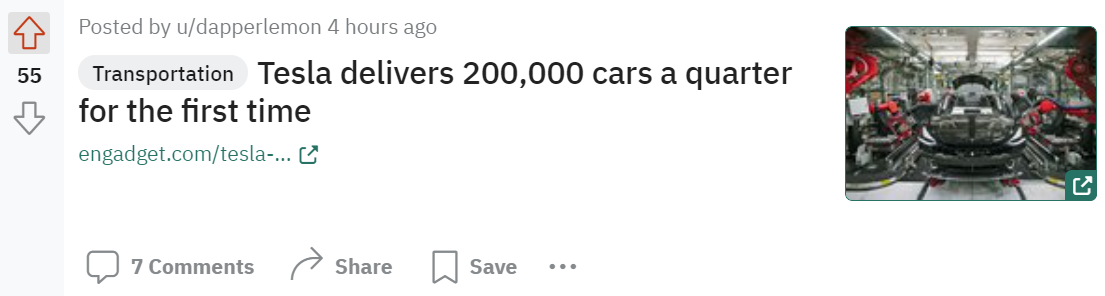

Das hier sichtbare Flair *Transportation* ist genau das, welches wir suchen. Leider ist die Welt allerdings nicht ganz so einfach, es gibt mehrere Schwierigkeiten:

1. Das Flair *Transportation* hieß früher nur *Transport*.
2. Die Flairs wurden von Reddit erst im Mai 2015 eingeführt.
3. Die Flairs werden nicht von allen Autoren konsistent verwendet.

All diese Probleme sind sehr typisch für Data Science-Projekte, weil häufig zunächst eine Bereinigung der Daten durchgeführt werden muss. Die Strategien unterscheiden sich dabei:
* Punkt 1 können wir sehr einfach lösen, indem wir einfach beide Flairs berücksichtigen.
* Punkt 2 und 3 sind deutlich schwieriger. Dazu trainieren wir einen Klassifikator und klassifizieren mit diesem einfach alle (Toplevel-) Posts neu. Die so gefundenen Posts verwenden wir dann als Datenmenge für die weitere Analyse.

## Achtung

Dieser Teil des Notebooks benötigt das gesamte Technology-Subreddit, das für den Download leider zu groß ist (10 GB). Daher ist dies im Colab-Notebook nicht ablauffähig! Eine Erklärung, wie man diese Daten selbst akquirieren kann, findet sich z.B. im Artikel [Beziehungssache](https://www.heise.de/select/ix/2021/7/2102513144636338770) in der aktuellen iX. 

Wir benötigen dies aber nur für die Erzeugung einer kleineren Datenmenge, die dann anschließend im Notebook ausschließlich verwendet wird und selbstverständlich heruntergeladen werden kann.

Bitte ab hier deshalb vorerst nur zuschauen!

In [ ]:
sql = sqlite3.connect("technology.db")

Wir bestimmen zunächst die Titel der Posts, die zu den Flairs *Transport* und *Transportation* gehören und nach dem 1.5.2015 gepostet wurden. Dies ist der positive Teil unserer Trainingsmenge.

In [ ]:
pos = pd.read_sql("SELECT created_utc, title FROM posts p\
                            WHERE parent_id IS NULL AND \
                                  (flair='Transport' OR \
                                   flair='Transportation') AND \
                                  created_utc>='2015-05-01'", 
                  sql, parse_dates=["created_utc"])
pos["target"] = 1

Nun selektieren wir alle Posts, die zu anderen Flairs gehören. Dabei berücksichtigen wir nicht die Posts ohne Flair, weil der Autor möglicherweise das Flair einfach vergessen hat.

In [ ]:
neg = pd.read_sql("SELECT created_utc, title FROM posts p\
                            WHERE parent_id IS NULL AND \
                                  (flair!='Transport' AND \
                                   flair!='Transportation' AND \
                                   flair IS NOT NULL) AND \
                                  created_utc>='2015-05-01'", 
                  sql, parse_dates=["created_utc"])
neg["target"] = 0

Wir erzeugen ein stratifizertes Datenset mit gleich vielen positiven wie negativen Beispielen:

In [ ]:
data = pd.concat([pos, neg.sample(n = len(pos), random_state=42)], 
                 ignore_index=True)

Nun werden die Daten vektorisiert. Wir verzichten hier auf Stopwords etc., die üblicherweise in der Textanalyse verwendet werden und vertrauen auf die Funktionsweise von TF/IDF:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.7, min_df=5)
tfidf_vectors = tfidf.fit_transform(data["title"])

Als Konvention nennen wir die unabhängige Variable `X` und die abhängige `Y`:

In [ ]:
X = tfidf_vectors
Y = data["target"].values

### Hold-out-Verfahren: Getrennte Mengen für Training und Test

Wir teilen die Datenmenge in einen Teil, mit dem wir den Klassifikator trainieren (75%) und eine, mit dem wir die Ergebnisse verproben:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

Das Klassifikationsmodell wird als Support Vector Machine nur mit Trainingsdaten trainiert:

In [ ]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
clf.fit(X_train, Y_train)

Wir führen eine Vorhersage für die (dem Klassifikator unbekannten) Testdaten durch:

In [ ]:
Y_predicted = clf.predict(X_test)

Und betrachten die Ergebnisse der Klassifikation:

In [ ]:
from sklearn import metrics
print(metrics.classification_report(Y_test, Y_predicted))

90% bzw. 96% Precision und Recall sind ziemlich gut, mit diesem Modell können wir arbeiten und nun alle Posts (größtenteils richtig) klassifizieren:

In [ ]:
all_posts = pd.read_sql("SELECT id, created_utc, title FROM posts p\
                            WHERE parent_id IS NULL", sql, parse_dates=["created_utc"])
all_posts["transport"] = clf.predict(tfidf.transform(all_posts["title"]))

In [ ]:
transport = all_posts[all_posts["transport"] == 1]
transport

Nach all der Vorarbeit haben wir nun die Daten selektiert, mit denen wir jetzt ausschließlich arbeiten werden. 

Der Vorbereitungsaufwand mag hoch erscheinen, allerdings haben wir nun auch wirklich ein Datenset, was genau zu unseren Geschäftsanforderungen passt. Mit manuellen Methoden wäre das nicht mit vertretbarem Aufwand möglich gewesen! 

Das ist auch ein Grund für die Beliebtheit von Data Science: mit relativ moderatem Aufwand können genau passende Datenmenge erzeugt werden!

Die Transport-Daten haben wir alle in einer SQLite-Datenbank abgespeichert, mit der wir jetzt weiterarbeiten werden. Danke für die Geduld!